# Calibration

Part of a [Recidivism Case Study](https://github.com/AllenDowney/RecidivismCaseStudy)

by [Allen Downey](https://allendowney.com)

[MIT License](https://opensource.org/licenses/MIT)

## Review

In the previous notebook we replicated the analysis reported in
"[Machine Bias](https://www.propublica.org/article/machine-bias-risk-assessments-in-criminal-sentencing)", by Julia Angwin, Jeff Larson, Surya Mattu and Lauren Kirchner, and published by [ProPublica](https://www.propublica.org) in May 2016.

After the ProPublica article, the Washington Post published a response by Sam Corbett-Davies, Emma Pierson, Avi Feller and Sharad Goel: "[A computer program used for bail and sentencing decisions was labeled biased against blacks. It’s actually not that clear.](https://www.washingtonpost.com/news/monkey-cage/wp/2016/10/17/can-an-algorithm-be-racist-our-analysis-is-more-cautious-than-propublicas/)".

I strongly encourage you to read both of those articles before you go on.  In this notebook, I explain some of the arguments presented in the Washington Post (WaPo) article, and we will replicate their analysis.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Data

The authors of "Machine Bias" published their data and analysis in [this repository](https://github.com/propublica/compas-analysis).

The terms of use for the data [are here](https://www.propublica.org/datastore/terms).  In compliance with those terms, I am not redistributing the data.

The following cell downloads the data file we'll use directly from their repository.

In [2]:
import os

if not os.path.exists('compas-scores-two-years.csv'):
    !wget https://github.com/propublica/compas-analysis/raw/master/compas-scores-two-years.csv

The following cell reads the data file:

In [3]:
cp = pd.read_csv("compas-scores-two-years.csv")
cp.shape

(7214, 53)

The dataset includes 7214 rows, one for each defendant, and 53 columns.

## Code

The functions from the previous notebook are in a file called `utils.py`; the following cell downloads it if you don't already have it:

In [4]:
import os

if not os.path.exists('utils.py'):
    !wget https://github.com/AllenDowney/RecidivismCaseStudy/utils.py

In [61]:
from utils import values
from utils import make_matrix
from utils import decorate
from utils import compute_metrics
from utils import predictive_value
from utils import error_rates
from utils import prevalence

## The WaPo response

The Washington Post article summarizes the ProPublica article and the response from Northpointe, the company that makes COMPAS:

* ProPublica claims that COMPAS is unfair because "among defendants who ultimately did not reoffend, blacks were more than twice as likely as whites to be classified as medium or high risk."

* Northpoint claims that COMPAS is fair because "scores mean essentially the same thing regardless of the defendant’s race. For example, among defendants who scored a seven on the COMPAS scale, 60 percent of white defendants reoffended, which is nearly identical to the 61 percent of black defendants who reoffended."

So ProPublica and Northpoint are invoking different definitions of "fair".

In the previous notebook we explored the first definition of "fair" by computing error rates (false positive and false negative) for white and black defendants.

In this notebook, we'll explore the second definition, which is called "calibration".  But first I want to address an important issue with this dataset: data bias

## Data bias

[**Note:** I wrote about data bias in the previous notebook, but I am repeating it here in case someone reads this notebook without reading the previous one.]

Systems like COMPAS are trying to predict whether a defendant will *commit* another crime if released.  But the dataset reports whether a defendant was *charged* with another crime.

Not everyone who commits a crime gets charged (not even close).  The probability of getting charged for a particular crime depends on the type of crime and location, the presence of witnesses and their willingness to work with police, the decisions of police about where to patrol, what crimes to investigate, and who to arrest, and decisions of prosecutors about who to charge.

It is likely that every one of these factors depends on the race of the defendant.  In this dataset, the prevalence of *new charges* is higher for black defendants, but that doesn't necessarily mean that the prevalence of *new crimes* is higher.  

If the dataset is affected by racial bias in the probability of being charged, prediction algorithms like COMPAS will be biased, too.  In discussions of whether and how these systems should be used in the criminal justice system, this is an important issue.  

However, I am going to put it aside *for now* in order to focus on understanding the arguments posed in the ProPublica article and the metrics they are based on.  For the rest of this notebook I will take the "recidivism rates" in the dataset at face value; but I will try to be clear about that they mean (and don't mean).

## Calibration

The WaPo article includes this figure, which shows "white and black defendants with the same risk score are roughly equally likely to reoffend."

<img width=90%, src='https://raw.githubusercontent.com/AllenDowney/ElementsOfDataScience/master/calibration1.png'>

To understand this figure, let's start by replicating it.

The following function groups defendants by risk score and computes the fraction in each group that were charged with another crime within two years.

In [41]:
def calibration_curve(df):
    """Fraction in each risk group charged with another crime.
    
    df: DataFrame
    
    returns: Series
    """
    grouped = df.groupby('decile_score')
    return grouped['two_year_recid'].mean()

The following figure shows this calibration curve for all defendants and broken down by race.

In [42]:
white = (cp['race'] == 'Caucasian')
white.name = 'white'
values(white)

False    4760
True     2454
Name: white, dtype: int64

In [43]:
black = (cp['race'] == 'African-American')
black.name = 'black'
values(black)

False    3518
True     3696
Name: black, dtype: int64

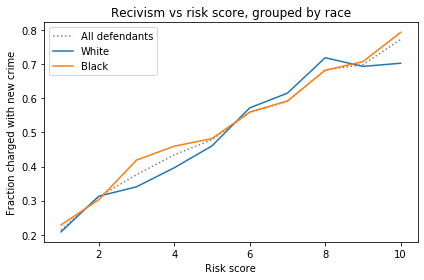

In [44]:
cal_all = calibration_curve(cp)
cal_all.plot(linestyle='dotted', 
              color='gray',
              label='All defendants')

cal_white = calibration_curve(cp[white])
cal_white.plot(label='White')

cal_white = calibration_curve(cp[black])
cal_white.plot(label='Black')

decorate(xlabel='Risk score',
         ylabel='Fraction charged with new crime',
         title='Recivism vs risk score, grouped by race')
plt.legend();

This figure shows that people with higher risk scores are more likely to be charged with a new crime within two years.  In that sense COMPAS works as intended; people with higher scores are more likely to recidivate.

Furthermore, the test is equally calibrated for black and white defendants; that is, in each risk group, the rate of recidivism is about the same for black and white defendants.

The WaPo article explains why this is important:

> A risk score of seven for black defendants should mean the same thing as a score of seven for white defendants. Imagine if that were not so, and we systematically assigned whites higher risk scores than equally risky black defendants with the goal of mitigating ProPublica’s criticism. We would consider that a violation of the fundamental tenet of equal treatment.

So we want a test that has the same calibration for all groups, and we want a test that has the same error rates for all groups.  

But there's the problem: as the WaPo article explains, it is mathematically impossible to be fair by both definitions at the same time.

To see why, let's go back to the confusion matrix.

## Matrices and metrics

As we saw in the previous notebook, here are the confusion matrices for white and black defendants.

In [45]:
matrix_white = make_matrix(cp, white)
matrix_white

Actual,Condition,No Condition
Predicted,,
Positive,505,349
Negative,461,1139


In [46]:
matrix_black = make_matrix(cp, black)
matrix_black

Actual,Condition,No Condition
Predicted,,
Positive,1369,805
Negative,532,990


And here are the metrics we computed from the confusion matrices:

In [47]:
metrics_white = compute_metrics(matrix_white, 
                                'White defendants')
metrics_white

,Percent
White defendants,
FP rate,23.454301
FN rate,47.722567
PPV,59.133489
NPV,71.187500
Prevalence,39.364303


In [48]:
metrics_black = compute_metrics(matrix_black, 
                                'Black defendants')
metrics_black

,Percent
Black defendants,
FP rate,44.846797
FN rate,27.985271
PPV,62.971481
NPV,65.045992
Prevalence,51.433983


If we look at the error rates , it seems like COMPAS is biased against black defendants:

* Their false positive rate is higher (45% vs 23%): among people who *will not* recidivate, black defendants are more likely to be classified high risk.

* Their false negative rate is lower (28% vs 48%): among people who *will* recidivate, black defendants are less likely to be classified low risk.

But if we look at the the predictive values (PPV and NPV) it seems like COMPAS is biased in favor of black defendants:

* Among people in the *high risk group*, black defendants are more likely to be arrested again (63% vs 59%).

* Among people in the *low risk group*, black defendants are less likely to "survive" two years without being arrested again (65% vs 71%).

It seems like we should be able to fix these problems, but it turns out that we can't.  

* If we make the error rates more equal, we make the predictive values more unfair, and the other way around; 

* If we make the predictive values more equal, we make the error rates more unfair.

Fundamentally, the problem is that the prevalence of recidivism is different in the two groups: about 39% of white defendants were charged with another crime within two years, compared to 51% of black defendants.

As long as that's the case (for any two groups) the predictive values and error rates can't be "fair" at the same time.

## Recreating the confusion matrix

To see why, consider this: the confusion matrix has four numbers in it, but they have to add up to 100%, so if you give me any three elements of the matrix, I can compute the fourth.

In the same way, if you provide any three (independent) metrics, I can compute the elements of the matrix and any other metrics.  Specifically:

* Given prevalence, PPV and NPV, we can compute the confusion matrix and the error rates.

* Given prevalence, FPR and FNR, we can compute the confusion matrix and the predictive values.

We could do the algebra by hand, but it is easier (and probably more reliable) to use SymPy.

Here are the symbols we'll use:

In [49]:
from sympy import symbols, Eq, solve

tn, fp, fn, tp = symbols('tn, fp, fn, tp')
ppv, npv, prev = symbols('ppv, npv, prev')
fpr, fnr = symbols('fpr, fnr')

And here are the equations that relate the metrics to the elements of the confusion matrix.

In [50]:
eq1 = Eq(prev, tp+fn)
eq1

Eq(prev, fn + tp)

In [51]:
eq2 = Eq(fpr, fp / (fp+tn))
eq2

Eq(fpr, fp/(fp + tn))

In [52]:
eq3 = Eq(fnr, fn / (fn+tp))
eq3

Eq(fnr, fn/(fn + tp))

In [53]:
eq4 = Eq(ppv, tp / (tp+fp))
eq4

Eq(ppv, tp/(fp + tp))

In [54]:
eq5 = Eq(npv, tn / (tn+fn))
eq5

Eq(npv, tn/(fn + tn))

In [55]:
eq6 = Eq(tn+fp+fn+tp, 1)
eq6

Eq(fn + fp + tn + tp, 1)

We can use `solve` to get expressions for the elements of the confusion matrix in terms of `ppv`, `npv`, and `prev`:

In [56]:
soln1 = solve([eq1, eq2, eq3, eq4, eq5, eq6], 
              [tp, fp, fn, tn, fpr, fnr])
soln1[0]

(ppv*(npv + prev - 1)/(npv + ppv - 1),
 -(ppv - 1)*(npv + prev - 1)/(npv + ppv - 1),
 -(npv - 1)*(ppv - prev)/(npv + ppv - 1),
 npv*(ppv - prev)/(npv + ppv - 1),
 (ppv - 1)*(npv + prev - 1)/((prev - 1)*(npv + ppv - 1)),
 -(npv - 1)*(ppv - prev)/(prev*(npv + ppv - 1)))

We can also solve for the elements of the confusion matrix in terms of `fpr`, `fnr`, and `prev`:

In [57]:
soln2 = solve([eq1, eq2, eq3, eq4, eq5, eq6], 
              [tp, fp, fn, tn, ppv, npv])

soln2[0]

(prev*(1 - fnr),
 fpr*(1 - prev),
 fnr*prev,
 (fpr - 1)*(prev - 1),
 prev*(fnr - 1)/(fnr*prev + fpr*prev - fpr - prev),
 (fpr - 1)*(prev - 1)/(fnr*prev + fpr*prev - fpr - prev + 1))

The following function takes `ppv`, `npv`, and `prev` and uses the expressions from `soln1` to compute a confusion matrix with those metrics.

In [58]:
def constant_predictive_value(ppv, npv, prev):
    """Make a confusion matrix with given metrics.
    
    ppv: positive predictive value (0-100)
    npv: negative predictive value (0-100)
    prev: prevalence (0-100)
    
    returns: confusion matrix
    """
    ppv /= 100
    npv /= 100
    prev /= 100
    a = np.array((ppv*(npv + prev - 1)/(npv + ppv - 1),
                -(ppv - 1)*(npv + prev - 1)/(npv + ppv - 1),
                -(npv - 1)*(ppv - prev)/(npv + ppv - 1),
                npv*(ppv - prev)/(npv + ppv - 1)))
    
    return pd.DataFrame(a.reshape((2, 2)))

To test it, I'll use metrics from the confusion matrix for all defendants.

In [59]:
all_defendants = np.ones_like(white)
matrix_all = make_matrix(cp, all_defendants)
metrics_all = compute_metrics(matrix_all, 'All defendants')
metrics_all

,Percent
All defendants,
FP rate,32.349230
FN rate,37.403876
PPV,61.350618
NPV,68.796510
Prevalence,45.065151


I'll extract PPV, NPV, and prevalence.

In [62]:
ppv, npv = predictive_value(matrix_all)
prev = prevalence(matrix_all)

Given those values, we can reconstruct the confusion matrix and compute the metrics again.

In [63]:
matrix = constant_predictive_value(ppv, npv, prev)
metrics_pred = compute_metrics(matrix)
metrics_pred

,Percent
,
FP rate,32.349230
FN rate,37.403876
PPV,61.350618
NPV,68.796510
Prevalence,45.065151


These "predicted metrics" are the same as the actual metrics, except for small errors due to floating-point approximation.

In [64]:
metrics_pred - metrics_all

,Percent
,
FP rate,0.000000e+00
FN rate,0.000000e+00
PPV,0.000000e+00
NPV,-1.421085e-14
Prevalence,0.000000e+00


So that confirms that we can use PPV, NPV and prevalence to compute FPR and FNR.

Now let's see what happens if we hold PPV and NPV constant, and vary prevalence.  First I'll extract the prevalence of recidivism for black defendants:

In [65]:
prev = metrics_black['Percent']['Prevalence']
prev

51.433982683982684

Using this prevalence, and holding PPV and NPV constant, we can predict error rates:

In [66]:
matrix = constant_predictive_value(ppv, npv, prev)
error_rates(matrix)

(53.40360542740529, 19.955904234916293)

FPR is substantially higher, and FNR substantially lower, compared to the error rates with lower prevalence.

We can do the same analysis for white defendants.

In [67]:
prev = metrics_white['Percent']['Prevalence']

In [68]:
matrix = constant_predictive_value(ppv, npv, prev)
error_rates(matrix)

(17.254472103643895, 57.81054940714234)

When prevalence is lower, the false positive rate is higher and the false negative rate lower.

## The constant predictive value model

To show these effects more clearly, I'll sweep through a range of prevalences and plot the error rates we get if we hold predictive values constant.

In [86]:
def run_cpv_model(cp):
    """Run the constant predictive value model.

    cp: DataFrame of COMPAS data

    returns: DataFrame with a row for each prevalence and
             a column for each metric (FPR, FNR)
    """
    matrix_all = make_matrix(cp)

    ppv, npv = predictive_value(matrix_all)
    prevalences = np.linspace(35, 55, 11)

    pred_er = pd.DataFrame(columns=['fpr', 'fnr'])

    for prev in prevalences:
        m = constant_predictive_value(ppv, npv, prev)
        pred_er.loc[prev] = error_rates(m)

    return pred_er

In [87]:
pred_er = run_cpv_model(cp)
pred_er

,fpr,fnr
35.0,7.488034,77.925569
37.0,11.795671,68.118564
39.0,16.385776,59.317406
41.0,21.287075,51.374897
43.0,26.532324,44.171227
45.0,32.159046,37.607882
47.0,38.210427,31.603121
49.0,44.736425,26.088543
51.0,51.795158,21.006482
53.0,59.454634,16.307973


The following figure shows the error rates we would expect from a test with equal predictive value for all groups, regardless of prevalence.

In [88]:
def plot_cpv_model(pred_er):
    """Plot error rates with constant predictive values.
    
    pred_er: DataFrame of predicted error rates
    """
    pred_er['fpr'].plot(label='Predicted FPR', color='C2')
    pred_er['fnr'].plot(label='Predicted FNR', color='C4')
    decorate(xlabel='Prevalence', ylabel='Percent',
             title='Error rates, constant predictive value')

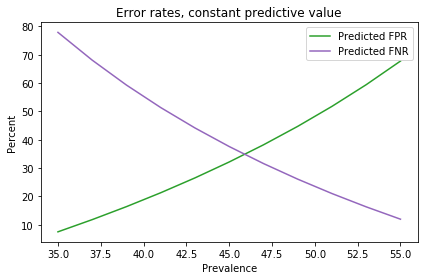

In [89]:
plot_cpv_model(pred_er)
plt.legend();

As prevalence increases, FPR increases and FNR decreases.  Note the vertical scale: the difference in error rates between a low-prevalence group and a high-prevalence group is dramatic!

For the COMPAS test, the effect is not as extreme.  The following loop computes the actual error rates for white, black, and all defendants.

In [90]:
actual_er = pd.DataFrame(columns=['fpr', 'fnr'])

for m in (matrix_white, matrix_all, matrix_black):
    prev = prevalence(m)
    actual_er.loc[prev] = error_rates(m)
    
actual_er

,fpr,fnr
39.364303,23.454301,47.722567
45.065151,32.349230,37.403876
51.433983,44.846797,27.985271


The following figure shows the actual error rates compared to predictions from the constant predictive value (CPV) model.

The data points show error rates for white defendants (left), all defendants (middle), and black defendants (right).

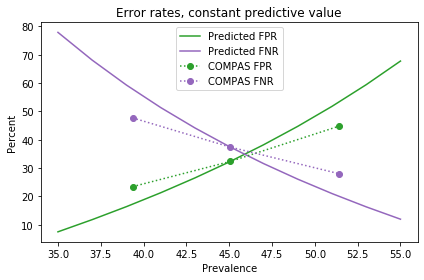

In [91]:
plot_cpv_model(pred_er)

actual_er['fpr'].plot(marker='o', linestyle='dotted', color='C2',
                      label='COMPAS FPR')

actual_er['fnr'].plot(marker='o', linestyle='dotted', color='C4',
                      label='COMPAS FNR')

plt.legend();

For the higher-prevalence group:

* The actual false positive rate is lower that what we would expect if the test had the same predictive value for all groups.

* The actual false negative rate is higher than expected.

For the lower-prevalence group:

* The actual false positive rate is higher than what we would expect if the test had the same predictive value for all groups.

* The actual false negative rate is lower than expected.

Relative to the CPV model, the COMPAS test is what I'll call "tempered", that is, less sensitive to variation in prevalence between groups.

## Constant error rate model

In the previous section we held predictive value constant and computed the effect on error rates.  In this section we'll go the other way: if we hold error rates constant for all groups, what effect does that have on predictive value?

The following function takes prevalence and error rates and returns a confusion matrix.



In [92]:
def constant_error_rates(fpr, fnr, prev):
    """Make a confusion matrix with given metrics.
    
    fpr: false positive rate (0 - 100)
    fnr: false negative rate (0 - 100)
    prev: prevalence (0 - 100)
    
    returns: confusion matrix
    """
    prev /= 100
    fpr /= 100
    fnr /= 100
    a = [[prev*(1 - fnr),  fpr*(1 - prev)],
         [fnr*prev,       (fpr - 1)*(prev - 1)]]
    
    return pd.DataFrame(a)

To test it, we can extract metrics for all defendants:

In [93]:
fpr, fnr = error_rates(matrix_all)
prev = prevalence(matrix_all)

And use them to compute the other metrics:

In [94]:
matrix = constant_error_rates(fpr, fnr, prev)
metrics_pred = compute_metrics(matrix)
metrics_pred

,Percent
,
FP rate,32.349230
FN rate,37.403876
PPV,61.350618
NPV,68.796510
Prevalence,45.065151


These "predicted metrics" are the same as the actual metrics, except for small errors due to floating-point approximation.

In [95]:
metrics_pred - metrics_all

,Percent
,
FP rate,0.000000e+00
FN rate,0.000000e+00
PPV,-7.105427e-15
NPV,1.421085e-14
Prevalence,0.000000e+00


Now we can see how predictive value depends on prevalence (with error rates held constant).

In [96]:
def run_cer_model(cp):
    """Run the constant error rate model.

    cp: DataFrame of COMPAS data

    returns: DataFrame with a row for each prevalence and
             a column for each metric (PPV, NPV)
    """
    matrix_all = make_matrix(cp)

    fpr, fnr = error_rates(matrix_all)
    prevalences = np.linspace(35, 65, 11)

    pred_pv = pd.DataFrame(columns=['ppv', 'npv'])

    for prev in prevalences:
        m = constant_error_rates(fpr, fnr, prev)
        pred_pv.loc[prev] = predictive_value(m)

    return pred_pv

In [97]:
pred_pv = run_cer_model(cp)
pred_pv

,ppv,npv
35.0,51.026704,77.058610
38.0,54.253815,74.689735
41.0,57.350053,72.243048
44.0,60.323222,69.714652
47.0,63.180516,67.100383
50.0,65.928580,64.395791
53.0,68.573560,61.596113
56.0,71.121148,58.696245
59.0,73.576628,55.690711
62.0,75.944906,52.573628


The following function plots results from the constant error rate (CER) model.

In [98]:
def plot_cer_model(pred_pv):
    """Plot error rates with constant predictive values.
    
    pred_er: DataFrame of predicted error rates
    """
    pred_pv['ppv'].plot(label='Predicted PPV', color='C0')
    pred_pv['npv'].plot(label='Predicted NPV', color='C1')
    decorate(xlabel='Prevalence', ylabel='Percent',
             title='Predictive value, constant error rates')

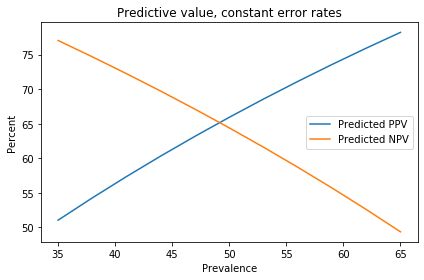

In [99]:
plot_cer_model(pred_pv)
plt.legend();

If we hold error rates constant and increase prevalence, PPV increases and NPV decreases.

For the COMPAS test, the effect is not as extreme.  The following loop computes the actual predictive values for the three groups.

In [100]:
actual_pv = pd.DataFrame(columns=['ppv', 'npv'])

for m in (matrix_white, matrix_all, matrix_black):
    prev = prevalence(m)
    actual_pv.loc[prev] = predictive_value(m)
    
actual_pv

,ppv,npv
39.364303,59.133489,71.187500
45.065151,61.350618,68.796510
51.433983,62.971481,65.045992


The following figure shows the actual predictive values compared to predictions from the constant error rate (CER) model.

The data points show error rates for white defendants (left), all defendants (middle), and black defendants (right).

The following figure shows the constant error rate model again, along with actual predictive values for white defendants (left), all defendants (middle), and black defendants (right).

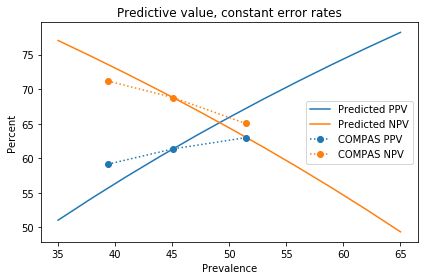

In [101]:
plot_cer_model(pred_pv)

actual_pv['ppv'].plot(marker='o', linestyle='dotted', color='C0',
                      label='COMPAS PPV')

actual_pv['npv'].plot(marker='o', linestyle='dotted', color='C1',
                      label='COMPAS NPV')

plt.legend();

Again, the test is less sensitive to differences in prevalence between groups than we would expect from the constant error rate model.



## Summary

An ideal test should have equal predictive value in all groups; that is, two people with the same risk score should have the same probability of recidivism, regardless of what group they are in.

An ideal test should also have the same error rates for all groups; that is, two non-recidivists should have the same probability of being classified as high risk.

Unfortunately, these two goals are in conflict:

* If you design a test to achieve equal predictive value across groups with different prevalence, you will find that error rates depend on prevalence.  Specifically, false positive rates will be higher in groups with higher rates of recividism.

* If you design a test to achieve equal error rates across groups, you will find that predictive value depends on prevalence.  Specifically, positive predictive value will be lower in groups with lower rates of recidivism.

Our analysis so far suggests that COMPAS was designed to achieve some balance between predictive values and error rates.

In groups with high prevalence:

* FPR is lower than we would expect if the test had the same predictive value in all groups.

* As a result, PPV is lower than we would expect if error rates were the same in all groups.

In summary, this notebook explored two claims reported in the WaPo article:

* COMPAS is calibrated; that it, the risk scores it assigns correspond to the same probability of recidivism for black and white defendants.

* In groups with different prevalence, it is not possible to have the same predictive values and the same error rates.

We found that these claims are substantially correct; additionally, we found that COMPAS achieves some balance between predictive value and error rates, which may or may not be deliberate.

In [the next notebook]() I apply the same analysis to evaluate the performance of COMPAS for male and female defendants.  I find that COMPAS is unfair to women, but in a way that's opposite what we have seen so far: the error rates are about the same for both groups, but the predictive values are substantially different.